# Replication: Sterling *etal*, 2016
## Introduction

This notebook attempts to replicate the following paper with [PPMI](http://ppmi-info.org) dataset:

<div class="alert alert-block alert-success">
Sterling, Nicholas W, et al. <a href=https://n.neurology.org/content/86/12/1143.short>Stage-dependent loss of cortical gyrification as Parkinson disease “unfolds”.</a> Neurology, vol. 86, no. 12, pp. 1143–1151, Mar. 2016. 
</div>

This study recruited 70 patients with PD without dementia and 70 control participants. Cortical local gyrification index (LGI) was compared between controls and PD subgroups based upon duration of illness. In the longitudinal cohort, PD<sub>L</sub> had significantly reduced overall gyrification, and bilaterally in the inferior parietal, postcentral, precentral, superior frontal, and superamarginal areas, compared to controls (*p* < 0.05). Longitudinally, loss of gyrification was accelerated in PD<sub>M</sub>, compared to controls. Demographic and clinical properties were as follows (table extracted from the paper):

<br>
<img src="demographics.png">

In [1]:
import os
import os.path as op
import math
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import livingpark_utils
from livingpark_utils import download
from livingpark_utils.dataset import ppmi
from livingpark_utils import clinical
from livingpark_utils.maketal.maketal import visit2month
from livingpark_utils.visualization import reformat_plot_labels

# Ignore warnings
warnings.filterwarnings("ignore")

# Style the plots
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.edgecolor"] = "none"
plt.rcParams["figure.autolayout"] = True

inputs_dir = os.path.join(os.getcwd(), "inputs/study_files")
outputs_dir = os.path.join(os.getcwd(), "outputs")
data_dir = os.path.join(os.getcwd(), "data")

utils = livingpark_utils.LivingParkUtils()
downloader = download.ppmi.Downloader(utils.study_files_dir)
utils.notebook_init()

This notebook was run on 2023-03-08 00:48:33 UTC +0000


## PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as much as possible. As in other LivingPark replications, we will use the same sample size as the original study. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

### Study data download

We will start by downloading the PPMI Study Data files required to build our cohort:

| File | Corresponding parameter |
| :----: | :----: |
| Age at visit | age |
| Socio Economics | education |
| MDS UPDRS Part III | UPDRS III values and H&Y scores |
| Montreal Cognitive Assessment MoCA | MMSE scores |
| PD Diagnosis History | Duration of illness (DOI) |
| LEDD Concomitant Medication log | LEDD values |
| Geriatric Depression Scale Short Version | GDS scores |


We will use LivingPark utils library to download these files from the notebook. If the files are already present, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).

In [2]:
required_files = [
    "Age_at_visit.csv",
    "Demographics.csv",
    "Socio-Economics.csv",
    "Participant_Status.csv",
    "MDS_UPDRS_Part_III.csv",
    "Montreal_Cognitive_Assessment__MoCA_.csv",
    "PD_Diagnosis_History.csv",
    "LEDD_Concomitant_Medication_Log.csv",
    "Geriatric_Depression_Scale__Short_Version_.csv",
]

utils.get_study_files(required_files, default=downloader)

Download skipped: No missing files!


### Cohort matching

### Participants (PD patients and healthy controls)

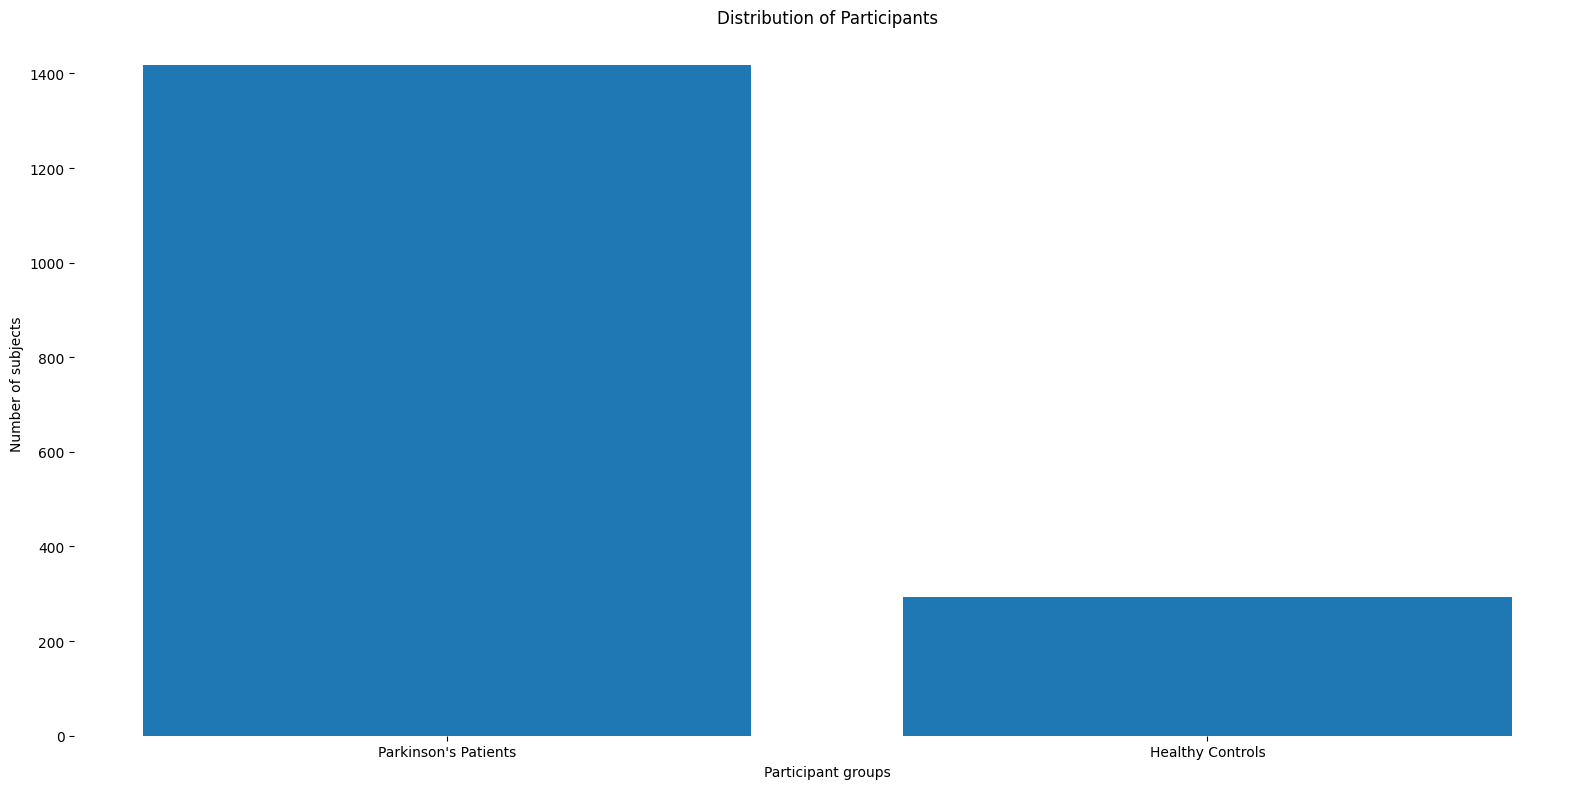

In [3]:
participants = pd.read_csv(os.path.join(inputs_dir, "Participant_Status.csv"))[
    ["PATNO", "COHORT"]
]
# Only keep PD (1) and HC (2)
participants = participants[participants["COHORT"].isin([1, 2])]

pd_patients = participants[participants["COHORT"] == 1]
hc = participants[participants["COHORT"] == 2]

prim_diag = pd.read_csv(os.path.join(inputs_dir, "Primary_Clinical_Diagnosis.csv"))[
    ["PATNO", "PRIMDIAG"]
]
# Only select subjects with no PD nor other neurological disoroder
prim_diag = prim_diag[prim_diag["PRIMDIAG"] == 17]

# Participants are considered healthy control if they have both PRIMADIAG 17 and COHORT 2
hc = hc.merge(prim_diag, on=["PATNO"]).drop(labels=["PRIMDIAG"], axis=1)

participants = pd.concat([pd_patients, hc]).drop_duplicates(
    subset=["PATNO"], keep="first"
)
# participants inplace=True)

dist = participants.groupby(["COHORT"]).size()
plt.bar(["Parkinson's Patients", "Healthy Controls"], dist.values)
plt.title("Distribution of Participants")
plt.xlabel("Participant groups")
plt.ylabel("Number of subjects");

### Duration of illness (DOI)

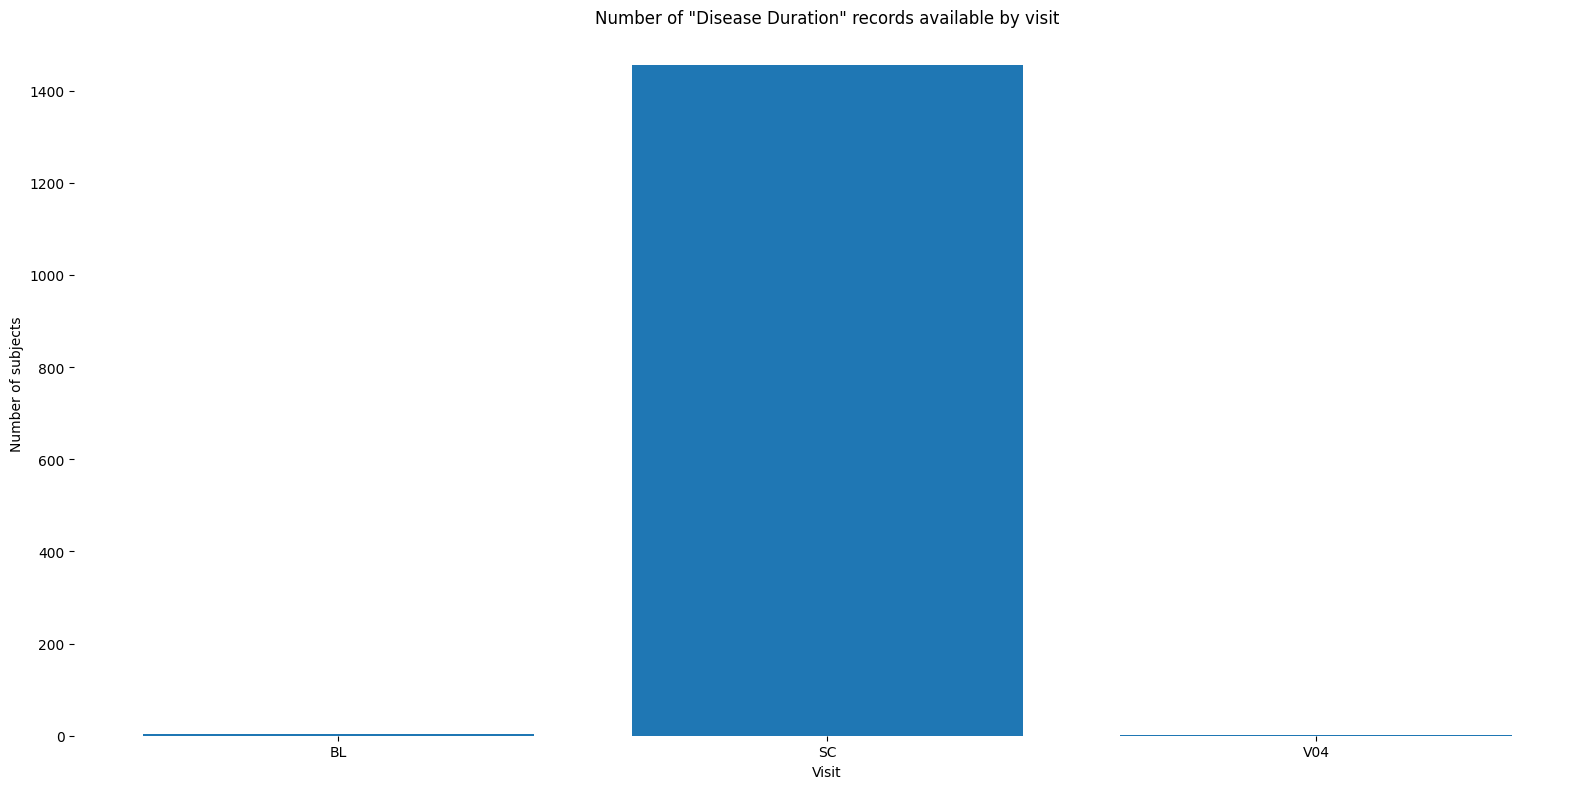

In [4]:
pddxdt = pd.read_csv(os.path.join(inputs_dir, "PD_Diagnosis_History.csv"))[
    ["PATNO", "EVENT_ID", "PDDXDT"]
]

dist = pddxdt.groupby(["EVENT_ID"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title('Number of "Disease Duration" records available by visit')
plt.xlabel("Visit")
plt.ylabel("Number of subjects");

We will only use the PD diagnosis taken at screening since it is by far the most frequent.

In [5]:
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

pddxdt = pddxdt[(pddxdt["EVENT_ID"] == "SC") & (pddxdt["PDDXDT"].notna())]

pdxdur = pd.read_csv(
    os.path.join(inputs_dir, "MDS_UPDRS_Part_III.csv"), low_memory=False
)[["PATNO", "EVENT_ID", "INFODT"]]

PDDXDT_map = dict(zip(pddxdt["PATNO"].values, pddxdt["PDDXDT"].values))
pdxdur["PDDXDT"] = pdxdur["PATNO"].map(PDDXDT_map)

pdxdur["PDXDUR"] = pdxdur.apply(
    lambda row: relativedelta(parse(row["INFODT"]), parse(row["PDDXDT"])).years
    if row["PDDXDT"] is not np.nan
    else np.nan,
    axis=1,
)

pdxdur.drop(labels=["INFODT", "PDDXDT"], inplace=True, axis=1)

### PD subgroups
Study divided PD patients in subgroups based upon duration of illness, defined as the number of years since diagnosis. PD<sub>E</sub> (<1 year), PD<sub>M</sub> (1-5 years), and PD<sub>L</sub> (>5 years).

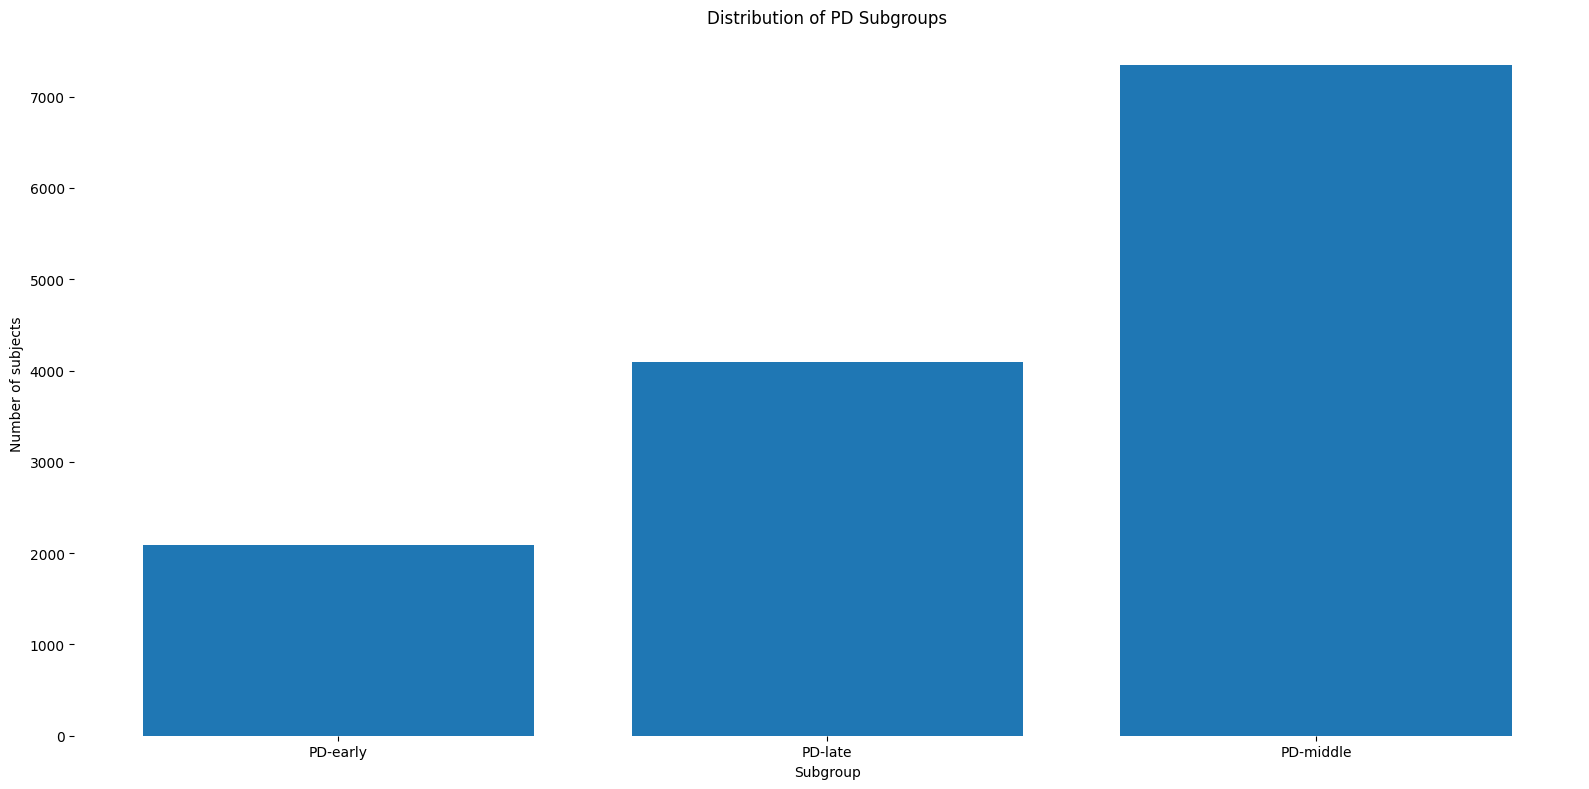

In [6]:
pdxdur["DOI"] = (
    pdxdur["PDXDUR"]
    .mask(pdxdur["PDXDUR"] < 1, "PD-early")
    .mask((pdxdur["PDXDUR"] >= 1) & (pdxdur["PDXDUR"] <= 5), "PD-middle")
    .mask(pdxdur["PDXDUR"] > 5, "PD-late")
)

fig, ax = plt.subplots()
dist = pdxdur.groupby(["DOI"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of PD Subgroups")
plt.xlabel("Subgroup")
plt.ylabel("Number of subjects");

### Examination scores

### Mini-Mental State Examination (MMSE)
The study selected patients with MMSE score ≥26 (without dementia).

0.0


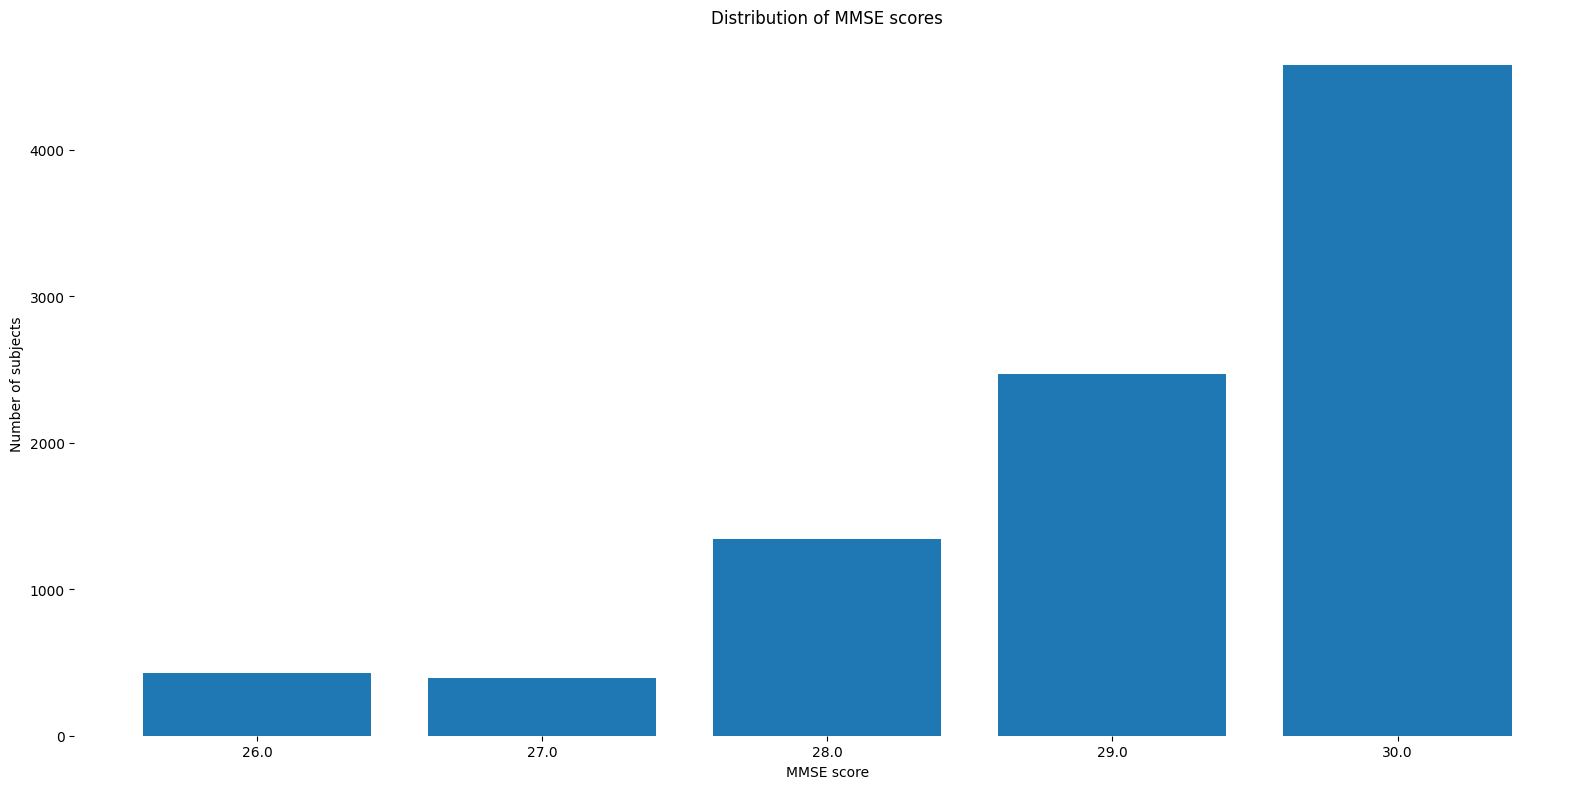

In [7]:
mmse = pd.read_csv(
    os.path.join(inputs_dir, "Montreal_Cognitive_Assessment__MoCA_.csv")
)[["PATNO", "EVENT_ID", "MCATOT"]]
mmse["MMSETOT"] = mmse["MCATOT"].apply(clinical.moca2mmse)
mmse = mmse.drop(["MCATOT"], axis=1)
mmse = mmse[mmse["MMSETOT"] >= 26]

dist = mmse.groupby(["MMSETOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of MMSE scores")
plt.xlabel("MMSE score")
plt.ylabel("Number of subjects");

### Hoehn & Yahr (H&Y)

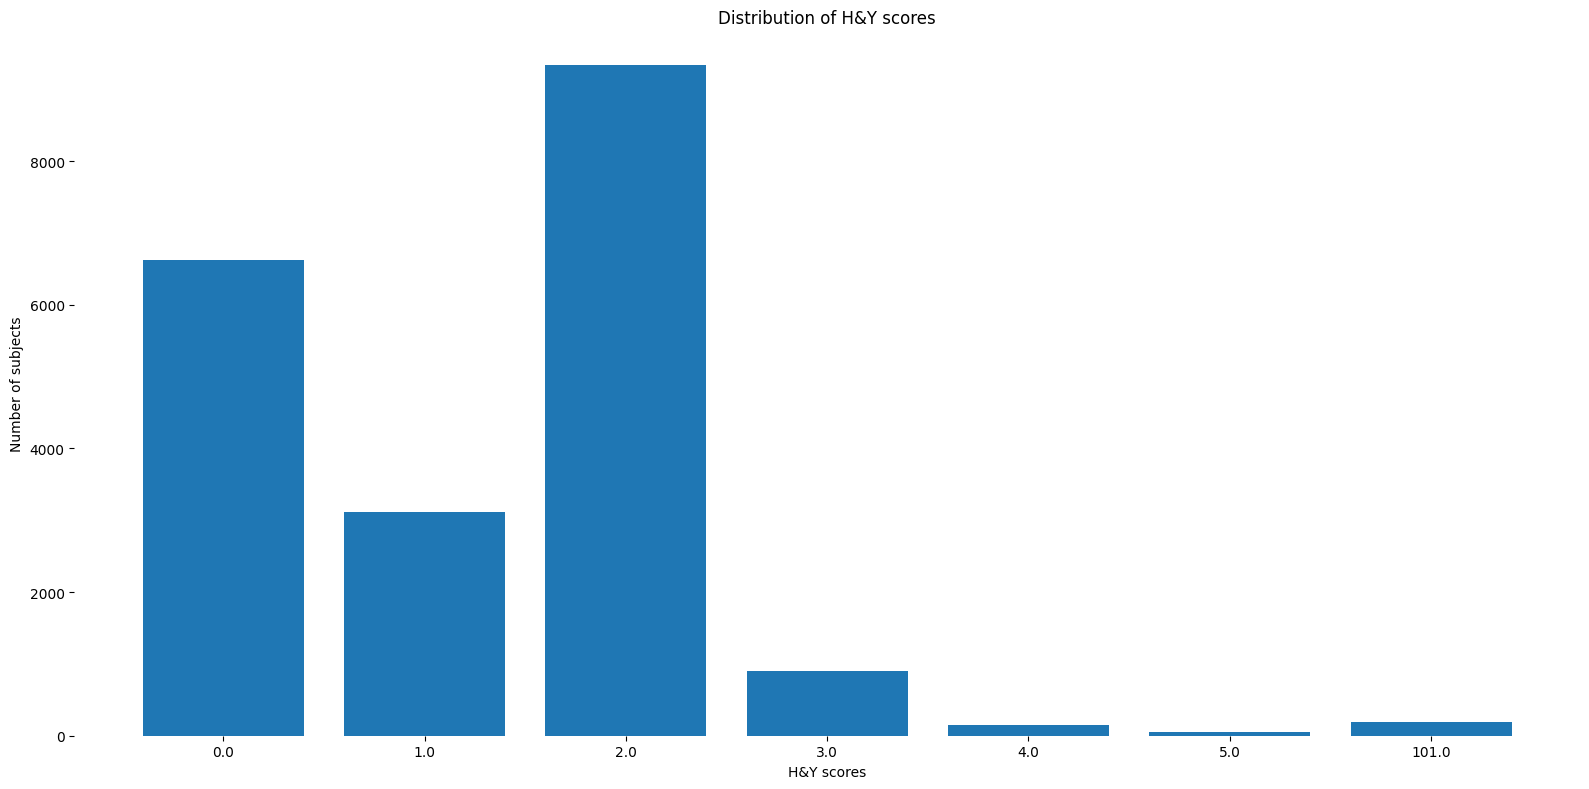

In [8]:
updrs3 = pd.read_csv(os.path.join(inputs_dir, "MDS_UPDRS_Part_III.csv"))[
    ["PATNO", "EVENT_ID", "PDSTATE", "PDTRTMNT", "NP3TOT", "NHY"]
]
updrs3 = updrs3[updrs3["NHY"].notna()]

dist = updrs3.groupby(["NHY"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of H&Y scores")
plt.xlabel("H&Y scores")
plt.ylabel("Number of subjects");

We remove the patients for which clinicians were unable to rate the H&Y score (UR).

In [9]:
updrs3 = updrs3[updrs3["NHY"] != "UR"]
updrs3["NHY"] = pd.to_numeric(updrs3["NHY"])

### Unified Parkinson's Disease Rating Scale, Part III (UPDRS III)

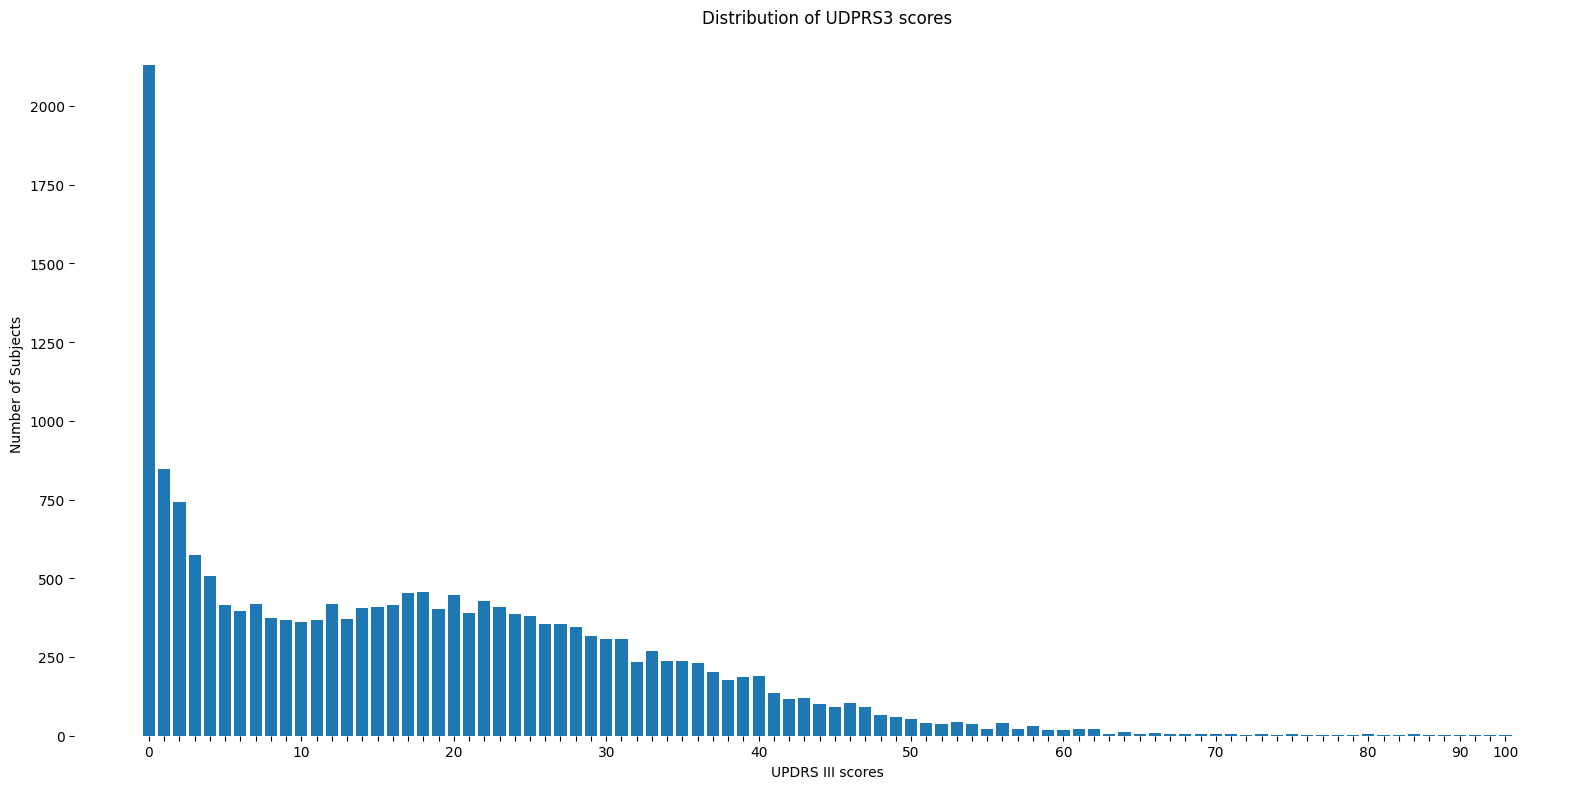

In [10]:
fig, ax = plt.subplots()

dist = updrs3.groupby(["NP3TOT"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of UDPRS3 scores")
plt.xlabel("UPDRS III scores")
plt.ylabel("Number of Subjects")

reformat_plot_labels(dist, ax, 10)

### Geriatric Depression Scale Short version (GDS)
Due to the absence of data on Hamilton Depression Scale, we will be using Geriatric Depression Scale. 

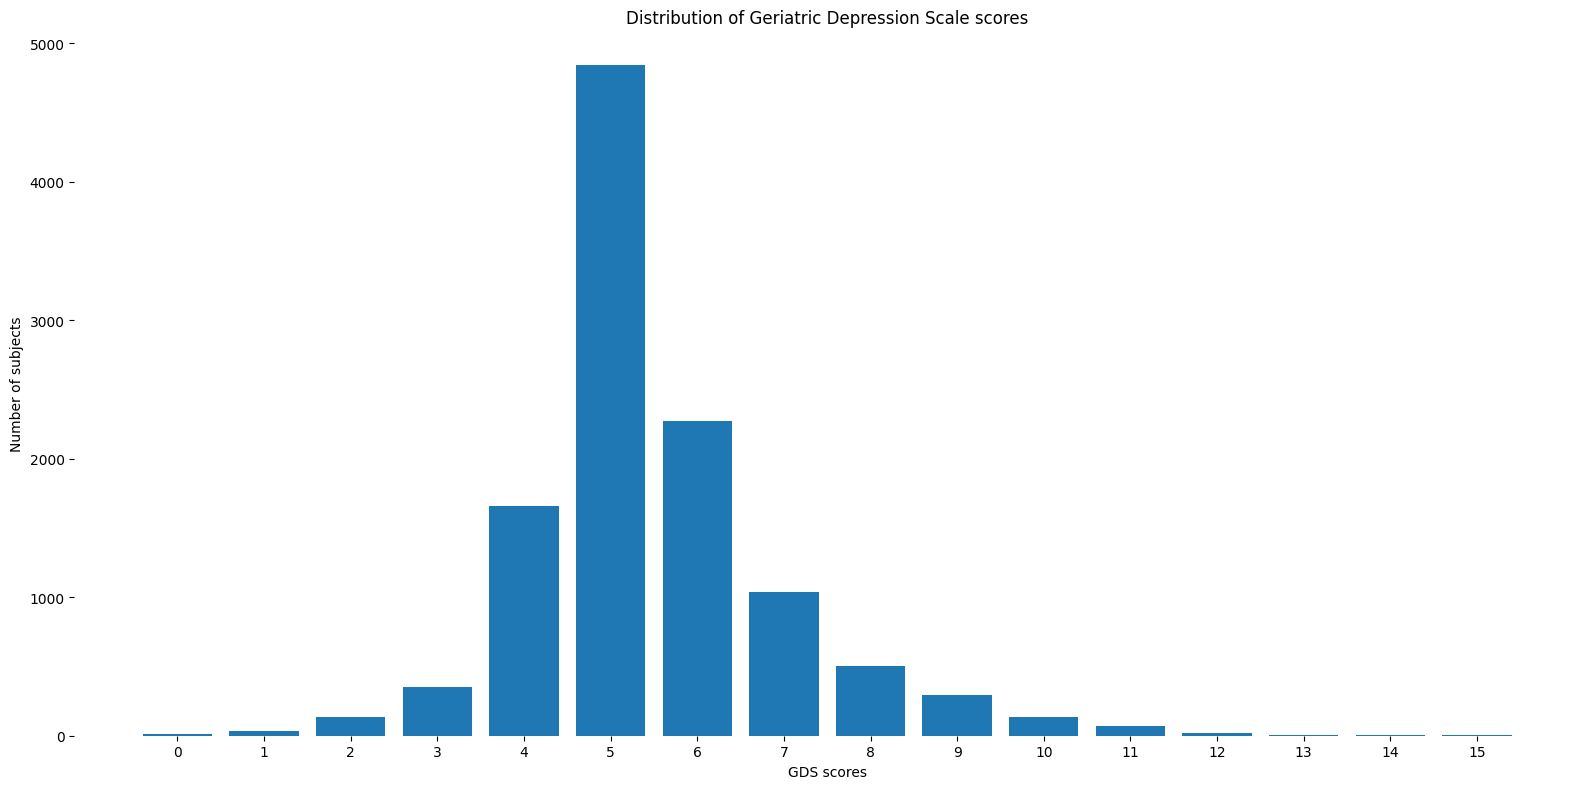

In [11]:
gds = pd.read_csv(
    os.path.join(inputs_dir, "Geriatric_Depression_Scale__Short_Version_.csv")
)
gds["GDSTOT"] = gds.drop(
    ["PATNO", "EVENT_ID", "REC_ID", "PAG_NAME", "INFODT", "LAST_UPDATE", "ORIG_ENTRY"],
    axis=1,
).sum(axis=1)
gds = gds[["PATNO", "EVENT_ID", "GDSTOT"]]

dist = gds.groupby(["GDSTOT"]).size()
plt.bar(dist.index.astype(int).astype(str), dist.values)
plt.title("Distribution of Geriatric Depression Scale scores")
plt.xlabel("GDS scores")
plt.ylabel("Number of subjects");

### Levodopa daily equivalent dosage (LEDD)

In [ ]:
ledd = pd.read_csv(os.path.join(inputs_dir, "LEDD_Concomitant_Medication_Log.csv"))[
    ["PATNO", "EVENT_ID", "LEDD"]
]

dist = ledd.groupby(["EVENT_ID"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title('Number of "Levodopa equivalent daily dose" records available by visit')
plt.xlabel("Visit")
plt.ylabel("Number of subjects");

We will only use LEDD data recorded at logs since it is by far the most frequent.

In [ ]:
ledd = ledd[ledd["EVENT_ID"] == "LOG"]
ledd = ledd[["PATNO", "LEDD"]]

# For PD medications except COMT inhibitors, the column LEDD will show the value of the
# Levodopa equivalent dose for that medication.

# For COMT inhibitors, the column LEDD will read “LD x 0.33” (for Entacapone) or “LD x 0.5”
# (for Tolcapone).

# To find the LEDD for COMT inhibitors, first find the total dose of Levodopa only,
# and then multiply the Levodopa dose by either 0.33 or 0.5 as instructed.

# Since Levodopa dose is mostly missing we will drop those.

ledd = ledd[ledd["LEDD"].notna()]  # Drop nan
ledd = ledd[ledd["LEDD"] != "LD x 0.33"]  # Drop LD x 0.33
ledd = ledd[ledd["LEDD"] != "LD x 0.5"]  # Drop LD x 0.5

ledd["LEDD"] = ledd["LEDD"].astype("float32")

dist = ledd.groupby(["LEDD"]).size()

plt.hist(ledd["LEDD"], zorder=3, bins=len(dist.index), rwidth=0.5)
plt.title('Distribution of "Levodopa equivalent daily dose" records')
plt.xlabel("LEDD (mg/d)")
plt.ylabel("Frequency");

### Demographics

### Sex

In [ ]:
sex = pd.read_csv(os.path.join(inputs_dir, "Demographics.csv"))[["PATNO", "SEX"]]
sex["SEX"] = sex["SEX"].astype(int)

dist = sex.groupby("SEX").size().rename({0: "Female", 1: "Male"})
plt.bar(dist.index, dist.values)
plt.title("Distribution of Sex")
plt.xlabel("Sex")
plt.ylabel("Number of subjects");

### Age at visit
We consider the age at specific visits (baseline and 36 months). However for simplicity, we only plot the age distribution at baseline.

In [ ]:
age = pd.read_csv(os.path.join(inputs_dir, "Age_at_visit.csv"))[
    ["PATNO", "EVENT_ID", "AGE_AT_VISIT"]
]

age[age["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].plot.hist(
    bins=25, title="Distribution of Age at Baseline", rwidth=0.9
)
plt.xlabel("Age (years)")
plt.ylabel("Number of subjects");

### Education
We only use the education years at screening as most of the other visits do not have records of it and most likely didn't change. In addition, when present, the education years at further visits showed inconsistency limiting the possibility to perform data imputation.

In [ ]:
edu = pd.read_csv(os.path.join(inputs_dir, "Socio-Economics.csv"))[
    ["PATNO", "EVENT_ID", "EDUCYRS"]
]
edu = edu[edu["EVENT_ID"] == "SC"].drop(["EVENT_ID"], axis=1)

edu["EDUCYRS"].plot.hist(bins=25, rwidth=0.7)
plt.title("Distribution of Education Years at Screening")
plt.xlabel("Education (years)")
plt.ylabel("Number of subjects");

### Data aggregation
We merge the data processed above to obtain a set of data with available:
- Duration of illness
- MMSE, H&Y, UPDRS III, and GDS scores
- Levodopa equivalent dosage
- Sex, age at visit, and education

In [ ]:
keys = ["PATNO", "EVENT_ID"]
df = (
    mmse.merge(pdxdur, on=keys)
    .merge(participants[participants["COHORT"] == 1], on=["PATNO"])
    .merge(updrs3, on=keys)
    #     .merge(gds, on=keys)  # Merging GDS drops the number of PD-early patients down close to zero
    .merge(ledd, on=["PATNO"])
    .merge(sex, on=["PATNO"])
    .merge(age, on=keys)
    .merge(edu, on=["PATNO"])
    .drop_duplicates()
    .groupby("PATNO")
    .filter(lambda x: x["EVENT_ID"].nunique() > 1)
)

pde_patno = df[df["DOI"] == "PD-early"]["PATNO"]
pdm_patno = df[df["DOI"] == "PD-middle"]["PATNO"]
pdl_patno = df[df["DOI"] == "PD-late"]["PATNO"]

<div class="alert alert-block alert-warning">
Note: Patients are divided into subgroups at baseline and can not transition from one subgroup to another in the following visits.
</div>

In [ ]:
print("Unique number of patients:", df["PATNO"].nunique())
print("Unique number of patients with PD-early:", pde_patno.nunique())
print("Unique number of patients with PD-middle:", pdm_patno.nunique())
print("Unique number of patients with PD-late:", pdm_patno.nunique())

print("\n" + df.groupby(["DOI", "EVENT_ID"])["PATNO"].nunique().to_string())

<div class="alert alert-block alert-danger">
Problem: There isn't any patient data available at baseline.
</div>

<div class="alert alert-block alert-success">
Solution: We can use data at screening as substitute for baseline.
</div>

In [ ]:
df["EVENT_ID"].mask(df["EVENT_ID"] == "SC", "BL", inplace=True)
print(
    "After Substitution:\n\n"
    + df.groupby(["DOI", "EVENT_ID"])["PATNO"].nunique().to_string()
)

<div class="alert alert-block alert-danger">
Problem: The number of patients at baseline in PD<sub>L</sub> is lower than the initial study (24).
</div>

<div class="alert alert-block alert-success">
Solution: We can use another visit with sufficient number of patients as baseline and adjust the 36 month follow up accordingly.
</div>

### Cohort sampling
We replicate the table from the initial study with the PPMI data.

In [ ]:
def sample_cohort(df, /, *, n_f, n_m, random_state=7):
    _df = df.drop_duplicates(subset=["PATNO"])
    n_f, n_m = min(_df.index.size, n_f), min(_df.index.size, n_m)
    df_f = _df[_df["SEX"] == 0].sample(n=n_f, replace=False, random_state=random_state)
    df_m = _df[_df["SEX"] == 1].sample(n=n_m, replace=False, random_state=random_state)
    return pd.concat([df_f, df_m])


def sample_followup(df, sample_df, months, n_f, n_m, random_state=7):
    df_f, df_m = (
        sample_df[sample_df["SEX"] == 0]["PATNO"],
        sample_df[sample_df["SEX"] == 1]["PATNO"],
    )
    event_id = visit2month[sample_df["EVENT_ID"].unique()[0]] + months
    event_id = list(visit2month.keys())[list(visit2month.values()).index(event_id)]

    _df_f = df[df["PATNO"].isin(df_f) & (df["EVENT_ID"] == event_id)].sample(
        n=n_f, replace=False, random_state=random_state
    )
    _df_m = df[df["PATNO"].isin(df_m) & (df["EVENT_ID"] == event_id)].sample(
        n=n_m, replace=False, random_state=random_state
    )
    return pd.concat([_df_f, _df_m])


pde_bl = sample_cohort(
    df[(df["DOI"] == "PD-early") & (df["EVENT_ID"] == "BL")], n_f=12, n_m=5
)
pde_36 = sample_followup(df, pde_bl, 36, n_f=7, n_m=3)

pdm_bl = sample_cohort(
    df[
        (df["DOI"] == "PD-middle")
        & (df["EVENT_ID"] == "BL")
        & ~df["PATNO"].isin(pde_bl["PATNO"].unique())
    ],
    n_f=9,
    n_m=20,
)
pdm_36 = sample_followup(df, pdm_bl, 36, n_f=8, n_m=15)

pdl_bl = sample_cohort(
    df[
        (df["DOI"] == "PD-late")
        & (df["EVENT_ID"] == "V04")
        & ~df["PATNO"].isin(pde_bl["PATNO"].unique())
        & ~df["PATNO"].isin(pdm_bl["PATNO"].unique())
    ],
    n_f=9,
    n_m=15,
)
pdl_36 = sample_followup(df, pdl_bl, 36, n_f=7, n_m=8)

pd_bl = pd.concat([pde_bl, pdm_bl, pdl_bl])
pd_36 = pd.concat([pde_36, pdm_36, pdl_36])